## Multi‑Channel: Top-Pop + SBERT + GRU4Rec

In [4]:
# ================================================================
# STEP 1: Imports & Global Config
# ================================================================
# Place in Cell 1

import os, math, json, random, time, gc
from dataclasses import dataclass
from typing import List, Dict, Tuple, Iterable
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Try importing sentence-transformers and faiss
try:
    from sentence_transformers import SentenceTransformer
except ImportError:
    raise ImportError("Please pip install sentence-transformers")
try:
    import faiss
except ImportError:
    raise ImportError("Please pip install faiss-cpu (or faiss-gpu)")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DATA_DIR = "/Users/zhanghengwei/Documents/9727project/project/zhw/inputs"   # Adjust to your local path (e.g., MINDlarge)
NEWS_PATH = os.path.join(DATA_DIR, "news.tsv")
BEHAVIORS_PATH = os.path.join(DATA_DIR, "behaviors.tsv")  # For dev/test you may load dev.tsv separately
OUTPUT_DIR = "/Users/zhanghengwei/Documents/9727project/project/zhw/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

MAX_HISTORY_LEN = 50  # for GRU sequences

In [5]:
# ================================================================
# STEP 2: Load Data (news & behaviors)
# ================================================================
# Place in Cell 2

news_cols = ['nid','category','subcategory','title','abstract','url','title_entities','abstract_entities']
news_df = pd.read_csv(NEWS_PATH, sep='\t', header=None, names=news_cols)
print("News shape:", news_df.shape)

# Basic text field (title + abstract)
news_df['abstract'] = news_df['abstract'].fillna('')
news_df['text'] = news_df['title'].fillna('') + ' [SEP] ' + news_df['abstract']

# Map news id to index
nid2idx = {nid:i for i, nid in enumerate(news_df['nid'].tolist())}
idx2nid = {i:nid for nid,i in nid2idx.items()}

# Load behaviors (Train). For evaluation you will typically have separate dev file.
beh_cols = ['impr_id','user_id','time','history','impressions']
behaviors_df = pd.read_csv(BEHAVIORS_PATH, sep='\t', header=None, names=beh_cols)
print("Behaviors shape:", behaviors_df.shape)

# Parse time
behaviors_df['time'] = pd.to_datetime(behaviors_df['time'])
behaviors_df = behaviors_df.sort_values('time').reset_index(drop=True)

# Utility parsing functions

def parse_history(h: str) -> List[str]:
    if isinstance(h, float) and math.isnan(h):
        return []
    if not h or h == '-':
        return []
    return h.strip().split(' ')

def parse_impressions(impr: str) -> List[Tuple[str,int]]:
    # each token like N12345-0 or N12345-1
    pairs = []
    for token in impr.split(' '):
        if '-' not in token: continue
        nid, label = token.rsplit('-',1)
        pairs.append((nid, int(label)))
    return pairs

# Add parsed columns (can be memory heavy; you can iterate on the fly instead)
behaviors_df['history_list'] = behaviors_df['history'].apply(parse_history)
behaviors_df['impr_list'] = behaviors_df['impressions'].apply(parse_impressions)

# Split train/val (simple time-based split)
split_time = behaviors_df['time'].quantile(0.8)
train_beh = behaviors_df[behaviors_df['time'] <= split_time].reset_index(drop=True)
val_beh = behaviors_df[behaviors_df['time'] > split_time].reset_index(drop=True)
print(f"Train impressions: {len(train_beh)}, Val impressions: {len(val_beh)}")

News shape: (51282, 8)
Behaviors shape: (156965, 5)
Train impressions: 125572, Val impressions: 31393


In [55]:
behaviors_df.head(5)

,impr_id,user_id,time,history,impressions,history_list,impr_list
0,20112,U65916,2019-11-09 00:00:19,N51706 N40767 N12096 N9798 N38802 N54827 N5780...,N54300-0 N46057-1 N57005-0 N52154-0 N57099-0 N...,"[N51706, N40767, N12096, N9798, N38802, N54827...","[(N54300, 0), (N46057, 1), (N57005, 0), (N5215..."
1,13807,U49985,2019-11-09 00:01:13,N5056 N29975 N53234 N39603 N50032 N8422 N53580...,N20602-0 N50059-0 N57768-1 N50135-1 N15134-0 N...,"[N5056, N29975, N53234, N39603, N50032, N8422,...","[(N20602, 0), (N50059, 0), (N57768, 1), (N5013..."
2,27660,U25550,2019-11-09 00:02:44,N17260 N38298 N33976 N47719 N14888 N18870 N4607,N50135-0 N15134-0 N52433-1 N20602-0 N64536-0,"[N17260, N38298, N33976, N47719, N14888, N1887...","[(N50135, 0), (N15134, 0), (N52433, 1), (N2060..."
3,152217,U19710,2019-11-09 00:02:50,N3530 N48284 N43019 N62546 N138 N13138 N10676 ...,N57099-0 N30295-0 N21086-0 N5379-0 N57005-0 N4...,"[N3530, N48284, N43019, N62546, N138, N13138, ...","[(N57099, 0), (N30295, 0), (N21086, 0), (N5379..."
4,42166,U38106,2019-11-09 00:03:09,N16874 N264 N48697 N51366,N3491-0 N20602-0 N25785-0 N23575-0 N38783-0 N1...,"[N16874, N264, N48697, N51366]","[(N3491, 0), (N20602, 0), (N25785, 0), (N23575..."


In [56]:
news_cols = ['nid','category','subcategory','title','abstract','url','title_entities','abstract_entities']
news = pd.read_csv(NEWS_PATH, sep='\t', header=None, names=news_cols)

In [57]:
news.head(5)

,nid,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [6]:
# ================================================================
# STEP 3: Popularity & Time-Decay Scores
# ================================================================
# Place in Cell 3

# Count clicks (label==1) and views for popularity
click_count = Counter()
view_count = Counter()

for _, row in tqdm(train_beh.iterrows(), total=len(train_beh), desc='Pop Stats'):
    for nid,label in row['impr_list']:
        view_count[nid] += 1
        if label == 1:
            click_count[nid] += 1

# Raw CTR
ctr = {}
for nid in view_count:
    ctr[nid] = click_count[nid] / (view_count[nid] + 1e-9)

# Optional time decay: weight each click by exp(-delta / tau)
# Simpler: recompute with decay if needed
TAU_DAYS = 5.0
click_decay = Counter()
ref_end = train_beh['time'].max()
for _, row in tqdm(train_beh.iterrows(), total=len(train_beh), desc='Time Decay'):
    t = row['time']
    decay = math.exp(- (ref_end - t).days / TAU_DAYS)
    for nid,label in row['impr_list']:
        if label == 1:
            click_decay[nid] += decay

# Normalize scores
pop_score = {}
for nid in view_count:
    score = click_decay[nid] if click_decay[nid] > 0 else click_count[nid]
    pop_score[nid] = score

# Convert to ranking percentile for later scaling
all_scores = np.array(list(pop_score.values()))
rank_scores = np.argsort(np.argsort(-all_scores))  # rank order
# Map back (optional). We'll keep pop_score raw; scaling done per impression

print("Popularity stats computed:", len(pop_score))

Time Decay: 100%|████████████████████| 125572/125572 [00:01<00:00, 68822.11it/s]

Popularity stats computed: 16832


In [7]:
# ================================================================
# STEP 4: SBERT Embeddings (News + Utility Functions)
# ================================================================
# Place in Cell 4

SBERT_MODEL_NAME = 'sentence-transformers/all-MiniLM-L12-v2'
embed_cache_path = os.path.join(OUTPUT_DIR, 'news_sbert.npy')

if os.path.exists(embed_cache_path):
    news_embeddings = np.load(embed_cache_path)
    print("Loaded cached embeddings:", news_embeddings.shape)
else:
    sbert_model = SentenceTransformer(SBERT_MODEL_NAME)
    texts = news_df['text'].tolist()
    batch_size = 256
    emb_list = []
    for i in tqdm(range(0, len(texts), batch_size), desc='SBERT encode'):
        batch = texts[i:i+batch_size]
        emb = sbert_model.encode(batch, batch_size=len(batch), show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
        emb_list.append(emb)
    news_embeddings = np.concatenate(emb_list, axis=0)
    np.save(embed_cache_path, news_embeddings)
    print("Encoded & saved embeddings:", news_embeddings.shape)

# Build FAISS index (cosine via inner product on normalized vectors)
faiss_index = faiss.IndexFlatIP(news_embeddings.shape[1])
faiss_index.add(news_embeddings)
print("FAISS index size:", faiss_index.ntotal)

# User embedding utility (weighted or simple average)

def build_user_sbert_vector(history: List[str], weight_recent: bool=True, alpha: float=0.1):
    if not history:
        return None
    vecs = []
    L = len(history)
    for pos, nid in enumerate(history[-MAX_HISTORY_LEN:]):  # last items
        if nid not in nid2idx: continue
        idx = nid2idx[nid]
        weight = math.exp(-alpha * (L - 1 - pos)) if weight_recent else 1.0
        vecs.append(news_embeddings[idx] * weight)
    if not vecs:
        return None
    u = np.sum(vecs, axis=0)
    norm = np.linalg.norm(u) + 1e-9
    return u / norm

Loaded cached embeddings: (51282, 384)
FAISS index size: 51282


In [8]:
# ================================================================
# STEP 5: Evaluation Metrics (Impression-level)
# ================================================================
# Place in Cell 5

from typing import List
import numpy as np

def ndcg_at_k(labels: List[int], k: int) -> float:
    # labels already ordered by predicted ranking
    rel = np.array(labels[:k])
    if rel.sum() == 0:
        return 0.0
    gains = (2**rel - 1)
    discounts = 1 / np.log2(np.arange(2, len(rel) + 2))
    dcg = (gains * discounts).sum()
    # Ideal DCG
    ideal_rel = np.sort(rel)[::-1]
    idcg = ( (2**ideal_rel - 1) * discounts[:len(ideal_rel)] ).sum()
    return dcg / (idcg + 1e-9)

def mrr_at_k(labels: List[int], k: int) -> float:
    for i, l in enumerate(labels[:k]):
        if l == 1:
            return 1.0 / (i + 1)
    return 0.0

def hit_at_k(labels: List[int], k: int) -> float:
    return 1.0 if 1 in labels[:k] else 0.0

def make_pr_eval_fn(val_impressions, nid2idx, device='cuda', k=10):
    def eval_fn(model):
        model.eval()
        tot_prec, tot_rec, tot_hit, tot_rel, cnt = 0.0, 0.0, 0.0, 0, 0
        with torch.no_grad():
            for imp in val_impressions:
                hist = imp['hist'][-50:]
                if not hist:  # 跳过冷启动（也可用pop兜底）
                    continue
                # ------- 计算 scores，同你已有的 gru_score_candidates -------
                pad_len = 50 - len(hist)
                seq = torch.tensor([[0]*pad_len + hist], device=device)
                h = model(seq)
                cand = torch.tensor(imp['candidates'], device=device)
                cand_emb = model.item_emb(cand)
                scores = (h * cand_emb).sum(-1).squeeze(0)

                # Top-K
                k_ = min(k, scores.size(0))
                order = torch.topk(scores, k_).indices.cpu().tolist()
                labels = imp['labels']
                rels   = [labels[i] for i in order]

                # precision & recall
                p = sum(rels)/k_
                r = sum(rels)/sum(labels) if sum(labels)>0 else 0.0

                tot_prec += p
                tot_rec  += r
                cnt += 1
        return tot_prec/cnt if cnt else 0.0, tot_rec/cnt if cnt else 0.0
    return eval_fn


# Diversity (mean pairwise cosine) using SBERT vectors
from itertools import combinations

def diversity_mean_pairwise_cosine(nid_list: List[str]) -> float:
    if len(nid_list) < 2: return 0.0
    idxs = [nid2idx[n] for n in nid_list if n in nid2idx]
    if len(idxs) < 2: return 0.0
    vecs = news_embeddings[idxs]
    # cosine since normalized
    sims = []
    for i,j in combinations(range(len(vecs)), 2):
        sims.append(float(np.dot(vecs[i], vecs[j])))
    if not sims: return 0.0
    return 1 - np.mean(sims)  # Higher => more diverse

In [9]:
# ================================================================
# STEP 6: Baseline Scoring Functions (Popularity, SBERT)
# ================================================================
# Place in Cell 6

def score_popularity(cand_nids: List[str]):
    # return raw popularity counts (will normalize per impression)
    return np.array([pop_score.get(nid, 0.0) for nid in cand_nids], dtype='float32')

def score_sbert(cand_nids: List[str], user_vec: np.ndarray):
    if user_vec is None:
        return np.zeros(len(cand_nids), dtype='float32')
    idxs = [nid2idx.get(n, -1) for n in cand_nids]
    out = []
    for idx in idxs:
        if idx == -1:
            out.append(0.0)
        else:
            out.append(float(np.dot(user_vec, news_embeddings[idx])))
    return np.array(out, dtype='float32')

# Normalization helper per impression

def normalize_scores(*arrays, method='minmax'):
    normed = []
    for arr in arrays:
        if len(arr) == 0:
            normed.append(arr)
            continue
        if method == 'minmax':
            mn, mx = float(arr.min()), float(arr.max())
            if mx - mn < 1e-9:
                normed.append(np.zeros_like(arr))
            else:
                normed.append((arr - mn) / (mx - mn))
        elif method == 'softmax':
            a = arr - arr.max()
            ex = np.exp(a)
            normed.append(ex / (ex.sum() + 1e-9))
        else:
            normed.append(arr)
    return normed

In [37]:
# ================================================================
# STEP 7: GRU4Rec Dataset & Model
# ================================================================
# Place in Cell 7

import random
import torch
from torch.utils.data import Dataset

class GRU4RecDataset(Dataset):
    """
    生成 (prefix_sequence, target_item) 样本：
    - progressive 序列 + stride 抽样 降低样本量
    - 每个用户可限制最大前缀样本数
    - 全局样本上限 max_samples
    - 序列统一左侧 padding=0
    """
    def __init__(self,
                 behaviors_df,
                 nid2idx,
                 max_len=50,
                 stride=5,
                 min_len=2,
                 max_prefixes_per_user=None,
                 max_samples=None,
                 seed=42):
        self.samples = []
        self.max_len = max_len
        rng = random.Random(seed)

        for _, row in behaviors_df.iterrows():
            hist = row['history_list']  # 你之前解析后的 list
            if not hist or len(hist) < min_len + 1:
                continue
            # 映射为 idx
            idx_hist = [nid2idx[h] for h in hist if h in nid2idx]
            if len(idx_hist) < min_len + 1:
                continue

            # progressive positions (target 在位置 t)
            positions = list(range(min_len + 1, len(idx_hist) + 1, stride))
            if positions[-1] != len(idx_hist):
                positions.append(len(idx_hist))  # 确保最后（完整前缀）样本

            if max_prefixes_per_user and len(positions) > max_prefixes_per_user:
                positions = rng.sample(positions, max_prefixes_per_user)

            for end in positions:
                prefix = idx_hist[:end-1]
                target = idx_hist[end-1]
                if len(prefix) > max_len:
                    prefix = prefix[-max_len:]
                self.samples.append((prefix, target))

        if max_samples and len(self.samples) > max_samples:
            self.samples = rng.sample(self.samples, max_samples)

        print(f"[GRU4RecDataset] samples={len(self.samples)}  (after stride / limits)")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, tgt = self.samples[idx]
        pad_len = self.max_len - len(seq)
        if pad_len > 0:
            seq = [0]*pad_len + seq
        return torch.tensor(seq, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

import torch
import torch.nn as nn
import torch.nn.functional as F

class GRU4RecCore(nn.Module):
    """
    只输出序列向量 h_last；不做全量 item logits。
    BPR / 采样 softmax 在训练循环里完成。
    """
    def __init__(self,
                 num_items,
                 emb_dim=128,
                 hidden_dim=128,
                 n_layers=1,
                 dropout=0.0,
                 padding_idx=0):
        super().__init__()
        self.item_emb = nn.Embedding(num_items + 1, emb_dim, padding_idx=padding_idx)  # idx=0 padding
        self.gru = nn.GRU(emb_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          batch_first=True,
                          dropout=0.2)
        self.proj = nn.Linear(hidden_dim, emb_dim) if hidden_dim != emb_dim else nn.Identity()

        nn.init.xavier_uniform_(self.item_emb.weight)
        if isinstance(self.proj, nn.Linear):
            nn.init.xavier_uniform_(self.proj.weight)

    def forward(self, seq_batch):
        """
        seq_batch: (B, L)
        return: (B, emb_dim) 序列最终表示
        """
        x = self.item_emb(seq_batch)          # (B,L,D)
        h_all, _ = self.gru(x)                # (B,L,H)
        lengths = (seq_batch != 0).sum(dim=1) # (B,)
        last_h = h_all[torch.arange(h_all.size(0)), lengths - 1]  # (B,H)
        return self.proj(last_h)              # (B,D)


In [38]:
# ================================================================
# STEP 8: Train GRU4Rec (Sampled Softmax simplified)
# ================================================================
# Place in Cell 8


import time
from torch.utils.data import DataLoader

def build_pop_sampler(pop_counts, num_items, alpha=0.0):
    """
    返回一个按 (pop^alpha) 分布采样的函数，alpha=0 -> uniform。
    pop_counts: dict {item_idx: click_count}
    """
    import numpy as np
    probs = np.ones(num_items + 1, dtype='float32')
    for k, v in pop_counts.items():
        if 1 <= k <= num_items:
            probs[k] = v
    probs[0] = 0
    probs = probs ** alpha
    probs = probs / probs.sum()
    item_ids = np.arange(num_items + 1)

    def sample(batch_size, neg_k):
        # 返回 torch.LongTensor shape (B, neg_k)
        idxs = np.random.choice(item_ids, size=(batch_size, neg_k), p=probs, replace=True)
        return torch.from_numpy(idxs)
    return sample

loss_list = []
prec_list = [] 
rec_list  = []

def train_gru_bpr(train_df,
                  nid2idx,
                  num_items,
                  epochs=3,
                  batch_size=1024,
                  emb_dim=128,
                  hidden_dim=128,
                  max_len=50,
                  stride=5,
                  max_prefixes_per_user=None,
                  max_samples=None,
                  neg_k=10,
                  lr=1e-3,
                  weight_decay=1e-5,
                  pop_counts=None,
                  alpha_pop=0.5,        # >0 使用 popularity 负采样
                  device='cuda',
                  num_workers=0,
                  use_amp=False,
                  max_grad_norm=5.0,
                  verbose=True,
                  seed=42,
                 valid_evaluator=None):
    """
    train_df: 需包含列 'history_list'（list[str]）
    pop_counts: {item_idx: click_count} 负采样可选
    """
    torch.manual_seed(seed)

    dataset = GRU4RecDataset(train_df,
                             nid2idx,
                             max_len=max_len,
                             stride=stride,
                             max_prefixes_per_user=max_prefixes_per_user,
                             max_samples=max_samples,
                             seed=seed)
    loader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers,
                        pin_memory=True,
                        persistent_workers=(num_workers > 0))

    model = GRU4RecCore(num_items,
                        emb_dim=emb_dim,
                        hidden_dim=hidden_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    if pop_counts and alpha_pop > 0:
        neg_sampler = build_pop_sampler(pop_counts, num_items, alpha=alpha_pop)
    else:
        neg_sampler = None

    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)
    
    for ep in range(1, epochs + 1):
        model.train()
        start = time.time()
        total_loss = 0.0
        total_examples = 0
    
        num_batches = len(loader)
        progress_interval = max(1, num_batches // 10)  # 每10%
    
        print(f"\n[Epoch {ep}] total batches: {num_batches}")
    
        for i, (seq_batch, pos_target) in enumerate(loader):
            # 打印进度（每10%）
            if (i + 1) % progress_interval == 0 or (i + 1) == num_batches:
                print(f"  → Progress: {(i + 1)}/{num_batches} ({(i + 1) / num_batches:.0%})")
    
            # 正常训练逻辑 ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
            seq_batch = seq_batch.to(device, non_blocking=True)
            pos_target = pos_target.to(device, non_blocking=True)
            B = pos_target.size(0)
    
            if neg_sampler:
                neg_ids = neg_sampler(B, neg_k).to(device)
            else:
                neg_ids = torch.randint(1, num_items + 1, (B, neg_k), device=device)
    
            with torch.cuda.amp.autocast(enabled=use_amp):
                h_last = model(seq_batch)
                pos_emb = model.item_emb(pos_target)
                neg_emb = model.item_emb(neg_ids)
    
                pos_score = (h_last * pos_emb).sum(-1, keepdim=True)
                neg_score = (h_last.unsqueeze(1) * neg_emb).sum(-1)
                loss = -torch.nn.functional.logsigmoid(pos_score - neg_score).mean()
    
            opt.zero_grad(set_to_none=True)
            if use_amp:
                scaler.scale(loss).backward()
                if max_grad_norm:
                    scaler.unscale_(opt)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                if max_grad_norm:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                opt.step()
    
            total_loss += loss.item() * B
            total_examples += B

        scheduler.step()
        
        avg_loss = total_loss / (total_examples + 1e-9)
        if verbose:
            print(f"[Epoch {ep}] BPR loss={avg_loss:.4f}  time={time.time()-start:.1f}s  samples={len(dataset)}")

        loss_list.append(avg_loss)
    
        # ——可选：在验证集计算 Precision@10——
        if valid_evaluator:                    # 你已有 evaluator 返回 NDCG, 下面示例返回 P@10
            prec_at_10, rec_at_10 = valid_evaluator(model)
            prec_list.append(prec_at_10)
            rec_list.append(rec_at_10)
        else:
            pass

    return model


def gru_score_candidates(model,
                         hist_indices,
                         candidate_indices,
                         max_len=50,
                         device='cuda'):
    """
    hist_indices: 用户历史 item idx 列表
    candidate_indices: list[int]
    return: list[float] 分数
    """
    model.eval()
    if not hist_indices:
        return [0.0] * len(candidate_indices)

    hist = hist_indices[-max_len:]
    pad_len = max_len - len(hist)
    seq_tensor = torch.tensor([[0]*pad_len + hist], dtype=torch.long, device=device)

    with torch.no_grad():
        h = model(seq_tensor)                            # (1,D)
        cand = torch.tensor(candidate_indices, dtype=torch.long, device=device)
        cand_emb = model.item_emb(cand)                  # (C,D)
        scores = (h * cand_emb).sum(-1).squeeze(0)       # (C,)
    return scores.detach().cpu().tolist()

# 统计 pop_counts（如果要 popularity 负采样）
from collections import Counter
pop_counts = Counter()
for _, row in train_beh.iterrows():
    for nid, label in row['impr_list']:  # 你的解析结构
        if label == 1 and nid in nid2idx:
            pop_counts[nid2idx[nid]] += 1

NUM_ITEMS = len(nid2idx)

val_impressions = []
for _, row in val_beh.iterrows():
    hist_ids = [nid2idx[n] for n in row['history_list'] if n in nid2idx]
    cand_ids = [nid2idx[n] for n, _ in row['impr_list'] if n in nid2idx]
    labels   = [lab        for _, lab in row['impr_list']]
    if not cand_ids:               # 没候选就跳过
        continue
    val_impressions.append({
        'hist': hist_ids,
        'candidates': cand_ids,
        'labels': labels
    })

val_eval_fn = make_pr_eval_fn(val_impressions, nid2idx, device=DEVICE)

gru_model = train_gru_bpr(
    train_df=train_beh,   # 只用训练集
    nid2idx=nid2idx,
    num_items=NUM_ITEMS,
    epochs=3,
    batch_size=1024,
    emb_dim=128,
    hidden_dim=128,
    max_len=50,
    stride=5,
    max_prefixes_per_user=12,      # 可调
    max_samples=500_000,           # 防止过大
    neg_k=10,
    lr=1e-3,
    pop_counts=pop_counts,
    alpha_pop=0.5,                 # 0=uniform; 0.3~0.5 轻微偏流行
    device=DEVICE,
    use_amp=True,
    valid_evaluator=val_eval_fn,
    weight_decay=1e-5
)

torch.save(gru_model.state_dict(), "gru4rec_bpr_3_epoch.pt")


[GRU4RecDataset] samples=500000  (after stride / limits)

[Epoch 1] total batches: 489


/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


  → Progress: 48/489 (10%)
  → Progress: 96/489 (20%)
  → Progress: 144/489 (29%)
  → Progress: 192/489 (39%)
  → Progress: 240/489 (49%)
  → Progress: 288/489 (59%)
  → Progress: 336/489 (69%)
  → Progress: 384/489 (79%)
  → Progress: 432/489 (88%)
  → Progress: 480/489 (98%)
  → Progress: 489/489 (100%)
[Epoch 1] BPR loss=0.1633  time=246.6s  samples=500000

[Epoch 2] total batches: 489
  → Progress: 48/489 (10%)
  → Progress: 96/489 (20%)
  → Progress: 144/489 (29%)
  → Progress: 192/489 (39%)
  → Progress: 240/489 (49%)
  → Progress: 288/489 (59%)
  → Progress: 336/489 (69%)
  → Progress: 384/489 (79%)
  → Progress: 432/489 (88%)
  → Progress: 480/489 (98%)
  → Progress: 489/489 (100%)
[Epoch 2] BPR loss=0.1159  time=349.3s  samples=500000

[Epoch 3] total batches: 489
  → Progress: 48/489 (10%)
  → Progress: 96/489 (20%)
  → Progress: 144/489 (29%)
  → Progress: 192/489 (39%)
  → Progress: 240/489 (49%)
  → Progress: 288/489 (59%)
  → Progress: 336/489 (69%)
  → Progress: 384/489 

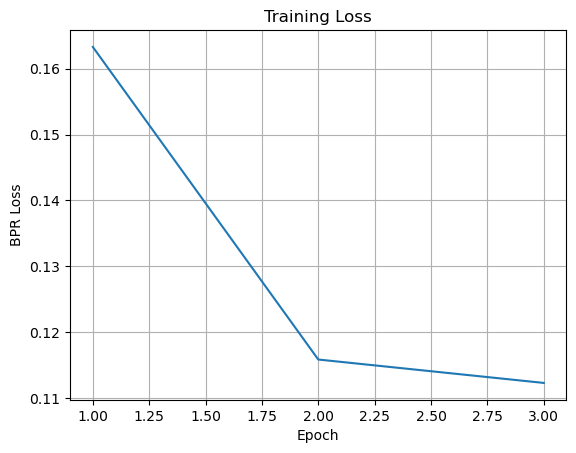

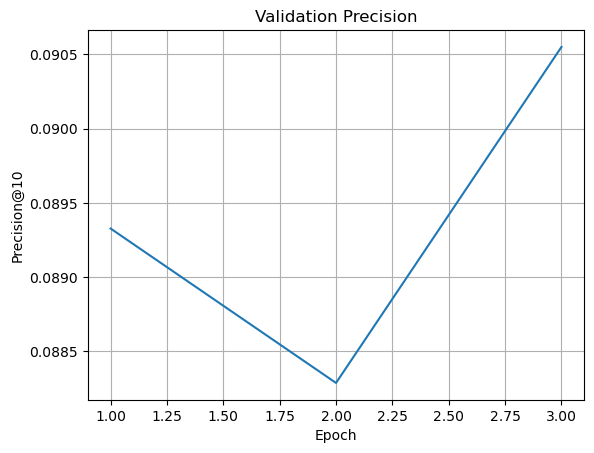

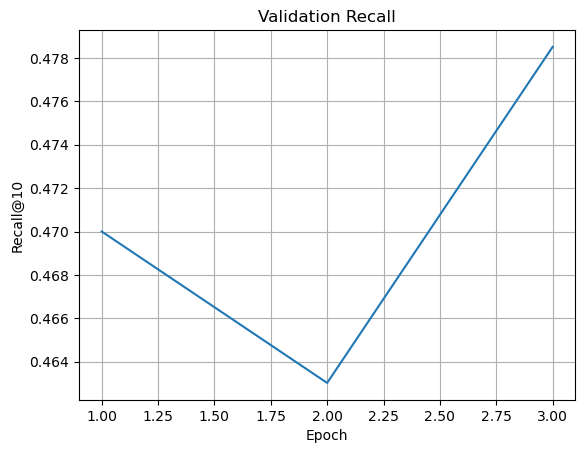

In [39]:
import matplotlib.pyplot as plt
epochs = range(1, len(loss_list)+1)

# Loss
plt.figure()
plt.plot(epochs, loss_list)
plt.xlabel('Epoch'); plt.ylabel('BPR Loss'); plt.title('Training Loss')
plt.grid(True); plt.show()

# Precision@10
plt.figure()
plt.plot(epochs, prec_list)
plt.xlabel('Epoch'); plt.ylabel('Precision@10'); plt.title('Validation Precision')
plt.grid(True); plt.show()

# Recall@10
plt.figure()
plt.plot(epochs, rec_list)
plt.xlabel('Epoch'); plt.ylabel('Recall@10'); plt.title('Validation Recall')
plt.grid(True); plt.show()


In [40]:
# ================================================================
# STEP 9: GRU Scoring for an Impression
# ================================================================
# Place in Cell 9

def score_gru(cand_nids: List[str], history: List[str], model: GRU4RecCore):
    if not history:
        return np.zeros(len(cand_nids), dtype='float32')

    # 构建 seq_tensor 同你原来的
    seq = [nid2idx[h] for h in history if h in nid2idx]
    # ... pad/truncate 省略
    seq_tensor = torch.tensor([seq], dtype=torch.long, device=DEVICE)

    with torch.no_grad():
        h_last = model(seq_tensor).squeeze(0)       # (hidden_dim,)
        item_weights = model.item_emb.weight       # (num_items+1, hidden_dim)

    scores = []
    for nid in cand_nids:
        idx = nid2idx.get(nid, None)
        if idx is None:
            scores.append(0.0)
        else:
            emb = item_weights[idx]                # (hidden_dim,)
            score = torch.dot(h_last, emb).item()  # 一个标量
            scores.append(score)

    return np.array(scores, dtype='float32')


In [48]:
# ================================================================
# STEP 10: Fusion (Weighted Sum & Logistic Regression)
# ================================================================
# Place in Cell 10

def fuse_weighted(spop, ssbert, sgru, w=(0.2,0.4,0.4)):
    return w[0]*spop + w[1]*ssbert + w[2]*sgru

# Collect training samples for logistic regression fusion using validation impressions (or part of train)

def build_fusion_training(beh_df, model: None, sample_limit=5000):
    X = []
    y = []
    for _, row in tqdm(beh_df.iterrows(), total=len(beh_df), desc='FusionCollect'):
        hist = row['history_list']
        impr = row['impr_list']
        cand_nids = [nid for nid,_ in impr]
        labels = [label for _,label in impr]
        user_vec = build_user_sbert_vector(hist)
        spop = score_popularity(cand_nids)
        ssbert = score_sbert(cand_nids, user_vec)
        sgru = score_gru(cand_nids, hist, model)
        # Normalize per channel
        spop_n, ssbert_n, sgru_n = normalize_scores(spop, ssbert, sgru, method='minmax')
        for i in range(len(cand_nids)):
            X.append([spop_n[i], ssbert_n[i], sgru_n[i]])
            y.append(labels[i])
        if len(X) >= sample_limit:
            break
    X = np.array(X); y = np.array(y)
    return X, y


NUM_ITEMS = len(nid2idx)  # 确保和训练时一致，比如 35839

print("NUM_ITEMS", NUM_ITEMS)

gru_model = GRU4RecCore(
    num_items=NUM_ITEMS,
    emb_dim=128,
    hidden_dim=128
).to(DEVICE)

gru_model.load_state_dict(torch.load("gru4rec_bpr_3_epoch.pt"))
gru_model.eval()

X_fuse, y_fuse = build_fusion_training(val_beh, gru_model)
print('Fusion training samples:', X_fuse.shape)
scaler = StandardScaler().fit(X_fuse)
X_scaled = scaler.transform(X_fuse)
logreg = LogisticRegression(max_iter=200).fit(X_scaled, y_fuse)
print('Fusion coefficients:', logreg.coef_, 'intercept:', logreg.intercept_)

# Predict function

def fuse_logistic(spop, ssbert, sgru):
    spop_n, ssbert_n, sgru_n = normalize_scores(spop, ssbert, sgru, method='minmax')
    feats = np.stack([spop_n, ssbert_n, sgru_n], axis=1)
    feats_scaled = scaler.transform(feats)
    probs = logreg.predict_proba(feats_scaled)[:,1]
    return probs

/Users/zhanghengwei/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


NUM_ITEMS 51282


FusionCollect:   0%|                       | 127/31393 [00:00<01:06, 472.23it/s]

Fusion training samples: (5069, 3)
Fusion coefficients: [[0.42725674 0.43368397 0.12036851]] intercept: [-3.40997892]


In [49]:
# ================================================================
# STEP 11: Optional MMR Re-ranking
# ================================================================
# Place in Cell 11

def mmr_rerank(cand_nids: List[str], base_scores: np.ndarray, lambda_=0.8, top_k=10):
    selected = []
    cand_set = set(range(len(cand_nids)))
    # Precompute embeddings for similarity (use SBERT)
    cand_vecs = [news_embeddings[nid2idx[n]] if n in nid2idx else np.zeros(news_embeddings.shape[1]) for n in cand_nids]
    cand_vecs = np.array(cand_vecs)
    for _ in range(min(top_k, len(cand_nids))):
        best = None
        best_value = -1e9
        for i in list(cand_set):
            if not selected:
                value = base_scores[i]
            else:
                sims = [float(np.dot(cand_vecs[i], cand_vecs[j])) for j in selected]
                max_sim = max(sims) if sims else 0.0
                value = lambda_ * base_scores[i] - (1 - lambda_) * max_sim
            if value > best_value:
                best_value = value
                best = i
        selected.append(best)
        cand_set.remove(best)
    return [cand_nids[i] for i in selected], [base_scores[i] for i in selected]

In [50]:
# ================================================================
# STEP 12: Full Evaluation Loop (Choose Fusion Type)
# ================================================================
# Place in Cell 12

FUSION_METHOD = 'logistic'  # or 'weighted'
WEIGHTS = (0.2,0.4,0.4)
K_AT = 10
use_mmr = True

metrics = {
    'ndcg@10': [], 'mrr@10': [], 'hit@10': [],
}

sample_diversity_ids = []  # collect final slates for diversity later

for _, row in tqdm(val_beh.iterrows(), total=len(val_beh), desc='Evaluate'):
    hist = row['history_list']
    impr_pairs = row['impr_list']
    if not impr_pairs: continue
    cand_nids = [nid for nid,_ in impr_pairs]
    labels = [label for _,label in impr_pairs]
    user_vec = build_user_sbert_vector(hist)
    spop = score_popularity(cand_nids)
    ssbert = score_sbert(cand_nids, user_vec)
    sgru = score_gru(cand_nids, hist, gru_model)
    if FUSION_METHOD == 'weighted':
        spop_n, ssbert_n, sgru_n = normalize_scores(spop, ssbert, sgru, method='minmax')
        final_scores = fuse_weighted(spop_n, ssbert_n, sgru_n, WEIGHTS)
    else:
        final_scores = fuse_logistic(spop, ssbert, sgru)
    # Rank
    order = np.argsort(-final_scores)
    ranked_labels = [labels[i] for i in order]
    ranked_nids = [cand_nids[i] for i in order]
    # Optional MMR (apply to top 20 then slice 10)
    if use_mmr:
        mmr_nids, _ = mmr_rerank(ranked_nids[:50], np.array(final_scores)[order][:50], lambda_=0.8, top_k=K_AT)
        # Need labels in new order
        mmr_labels = [1 if any((n==nid and lbl==1) for (nid,lbl) in impr_pairs) else 0 for n in mmr_nids]
        ranked_labels = mmr_labels
        ranked_nids = mmr_nids
    # Metrics
    metrics['ndcg@10'].append(ndcg_at_k(ranked_labels, K_AT))
    metrics['mrr@10'].append(mrr_at_k(ranked_labels, K_AT))
    metrics['hit@10'].append(hit_at_k(ranked_labels, K_AT))
    sample_diversity_ids.append(ranked_nids[:K_AT])

print({m: np.mean(v) for m,v in metrics.items()})

# Diversity & coverage
all_recommended = [nid for slate in sample_diversity_ids for nid in slate]
coverage = len(set(all_recommended)) / len(news_df)
diversity_vals = [diversity_mean_pairwise_cosine(slate) for slate in sample_diversity_ids]
print("Coverage:", coverage, "Mean Diversity:", np.mean(diversity_vals))

Evaluate: 100%|██████████████████████████| 31393/31393 [01:22<00:00, 378.58it/s]


{'ndcg@10': 0.34190984587716083, 'mrr@10': 0.25977081889148274, 'hit@10': 0.6133532953206129}
Coverage: 0.06436956436956437 Mean Diversity: 0.9399653985859848


In [51]:
# ================================================================
# STEP 13: Ablation / Variant Runner (Optional)
# ================================================================
# Place in Cell 13

import datetime

variant_results = []

def run_variant(use_pop=True, use_sbert=True, use_gru=True, fusion='weighted'):
    metrics_local = {'ndcg@10': [], 'mrr@10': [], 'hit@10': []}
    for _, row in val_beh.iterrows():
        hist = row['history_list']
        impr_pairs = row['impr_list']
        if not impr_pairs: continue
        cand_nids = [nid for nid,_ in impr_pairs]
        labels = [label for _,label in impr_pairs]
        user_vec = build_user_sbert_vector(hist) if use_sbert else None
        spop = score_popularity(cand_nids) if use_pop else np.zeros(len(cand_nids))
        ssbert = score_sbert(cand_nids, user_vec) if use_sbert else np.zeros(len(cand_nids))
        sgru = score_gru(cand_nids, hist, gru_model) if use_gru else np.zeros(len(cand_nids))
        if fusion == 'weighted':
            s_norm = normalize_scores(spop, ssbert, sgru, method='minmax')
            final_scores = fuse_weighted(*s_norm, w=(1/3,1/3,1/3))
        else:
            final_scores = fuse_logistic(spop, ssbert, sgru)
        order = np.argsort(-final_scores)
        ranked_labels = [labels[i] for i in order]
        metrics_local['ndcg@10'].append(ndcg_at_k(ranked_labels, 10))
        metrics_local['mrr@10'].append(mrr_at_k(ranked_labels, 10))
        metrics_local['hit@10'].append(hit_at_k(ranked_labels, 10))
    return {m: np.mean(v) for m,v in metrics_local.items()}

ablation_settings = [
    (True, False, False, 'weighted', 'Pop only'),
    (False, True, False, 'weighted', 'SBERT only'),
    (False, False, True, 'weighted', 'GRU only'),
    (True, True, False, 'weighted', 'Pop+SBERT'),
    (True, False, True, 'weighted', 'Pop+GRU'),
    (False, True, True, 'weighted', 'SBERT+GRU'),
    (True, True, True, 'weighted', 'All Weighted'),
    (True, True, True, 'logistic', 'All Logistic'),
]

for p,s,g,f,name in ablation_settings:
    start_ts = datetime.datetime.now()
    print(f"[{start_ts:%Y-%m-%d %H:%M:%S}] ▶️ Starting variant: {name}")
    
    res = run_variant(p,s,g,f)
    res['variant'] = name
    variant_results.append(res)

    end_ts = datetime.datetime.now()
    delta = (end_ts - start_ts).total_seconds()
    print(f"[{end_ts:%Y-%m-%d %H:%M:%S}] ✅ Finished variant: {name} (elapsed {delta:.2f}s)\n")

ablation_df = pd.DataFrame(variant_results)
print(ablation_df)

[2025-07-24 15:47:37] ▶️ Starting variant: Pop only
[2025-07-24 15:47:39] ✅ Finished variant: Pop only (elapsed 1.44s)

[2025-07-24 15:47:39] ▶️ Starting variant: SBERT only
[2025-07-24 15:47:42] ✅ Finished variant: SBERT only (elapsed 3.68s)

[2025-07-24 15:47:42] ▶️ Starting variant: GRU only
[2025-07-24 15:48:19] ✅ Finished variant: GRU only (elapsed 36.90s)

[2025-07-24 15:48:19] ▶️ Starting variant: Pop+SBERT
[2025-07-24 15:48:23] ✅ Finished variant: Pop+SBERT (elapsed 4.01s)

[2025-07-24 15:48:23] ▶️ Starting variant: Pop+GRU
[2025-07-24 15:49:03] ✅ Finished variant: Pop+GRU (elapsed 39.85s)

[2025-07-24 15:49:03] ▶️ Starting variant: SBERT+GRU
[2025-07-24 15:49:45] ✅ Finished variant: SBERT+GRU (elapsed 42.35s)

[2025-07-24 15:49:45] ▶️ Starting variant: All Weighted
[2025-07-24 15:50:31] ✅ Finished variant: All Weighted (elapsed 46.03s)

[2025-07-24 15:50:31] ▶️ Starting variant: All Logistic
[2025-07-24 15:51:20] ✅ Finished variant: All Logistic (elapsed 48.20s)

    ndcg@10  

In [52]:
# ================================================================
# STEP 14: Significance Test (Paired t-test) Final vs Baseline
# ================================================================
# Place in Cell 14

import time
from scipy import stats

# 准备工作
rows = list(val_beh.itertuples(index=False))  # 或者直接 N = len(val_beh)
N = len(rows)
step = max(1, N // 10)

final_scores_list   = []
weighted_scores_list = []

for i, row in enumerate(rows, start=1):
    # —— 每 10% 打印一次进度
    if i % step == 0 or i == N:
        print(f"▶️ Progress: {i}/{N} ({i/N:.0%})")

    t0 = time.time()

    hist       = row.history_list
    impr_pairs = row.impr_list
    if not impr_pairs:
        continue

    cand_nids = [nid for nid, _ in impr_pairs]
    labels    = [lab for _, lab in impr_pairs]

    user_vec = build_user_sbert_vector(hist)
    spop     = score_popularity(cand_nids)
    ssbert   = score_sbert(cand_nids, user_vec)
    sgru     = score_gru(cand_nids, hist, gru_model)

    # logistic 融合打分
    logistic_scores   = fuse_logistic(spop, ssbert, sgru)
    order_log         = np.argsort(-logistic_scores)
    ranked_labels_log = [labels[j] for j in order_log]
    ndcg_log          = ndcg_at_k(ranked_labels_log, 10)

    # 加权融合打分
    spop_n, ssbert_n, sgru_n = normalize_scores(spop, ssbert, sgru, method='minmax')
    weighted_scores = fuse_weighted(spop_n, ssbert_n, sgru_n, (1/3, 1/3, 1/3))
    order_w         = np.argsort(-weighted_scores)
    ranked_labels_w = [labels[j] for j in order_w]
    ndcg_w          = ndcg_at_k(ranked_labels_w, 10)

    final_scores_list.append(ndcg_log)
    weighted_scores_list.append(ndcg_w)

    t1 = time.time()
    # 可选：打印这一条耗时
    # print(f"    iter {i} done — {(t1-t0):.3f}s")

# 最后做 t‑检验
stat, pval = stats.ttest_rel(final_scores_list, weighted_scores_list)
print(f"\nPaired t‑test logistic vs weighted: stat={stat:.4f}  p={pval:.4e}")

▶️ Progress: 3139/31393 (10%)
▶️ Progress: 6278/31393 (20%)
▶️ Progress: 9417/31393 (30%)
▶️ Progress: 12556/31393 (40%)
▶️ Progress: 15695/31393 (50%)
▶️ Progress: 18834/31393 (60%)
▶️ Progress: 21973/31393 (70%)
▶️ Progress: 25112/31393 (80%)
▶️ Progress: 28251/31393 (90%)
▶️ Progress: 31390/31393 (100%)
▶️ Progress: 31393/31393 (100%)

Paired t‑test logistic vs weighted: stat=10.7909  p=4.2428e-27


In [53]:
# ================================================================
# STEP 15: Save Key Artifacts
# ================================================================
# Place in Cell 15

np.save(os.path.join(OUTPUT_DIR,'variant_results_epoch_3.npy'), ablation_df.to_dict('records'))
with open(os.path.join(OUTPUT_DIR,'metrics_summary.json'),'w') as f:
    json.dump({m: float(np.mean(v)) for m,v in metrics.items()}, f, indent=2)
print("Artifacts saved in", OUTPUT_DIR)

Artifacts saved in /Users/zhanghengwei/Documents/9727project/project/zhw/outputs


In [54]:
# ================================================================
# STEP 16: (Optional) Cleanup / Free GPU Memory
# ================================================================
# Place in Cell 16

del gru_model; gc.collect(); torch.cuda.empty_cache() if torch.cuda.is_available() else None
print("Cleanup done.")

# ================================================================
# END OF STEP-BY-STEP NOTEBOOK SCAFFOLD
# ================================================================

Cleanup done.
